In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
#A function to determine outliers. 
#From here http://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data/22357811#22357811

def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [12]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

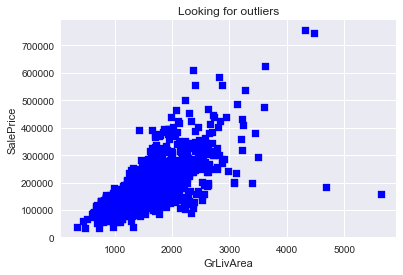

In [13]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [14]:
# Removing all homes with a living area (GR LIVE AREA) above 4000 square feet(as per the outliers identified above)
train = train[train.GrLivArea < 4000]
# Eliminating all sales except for the “normal” from the SALES CONDITION variable. 
train = train[train.SaleCondition == 'Normal']

In [15]:
len(train)

1197

In [16]:
## get all features except Id and SalePrice
feats = train.columns.difference(['Id','SalePrice'])

# the most hassle free way of working with data is to concatenate them
# since there are many features that contain nan/null values in the test set
# that the train set doesn't
all_data = pd.concat((train.loc[:,feats], test.loc[:,feats]))

In [19]:
all_data.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008
5,796,566,320,NaN,1,1Fam,TA,No,732.0,0.0,...,WD,0,Pave,5,796.0,AllPub,40,1993,1995,2009


##### Transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal
- log transformed certain features for which the skew was > 0.75.
- This will make the feature more normally distributed and this makes linear regression perform better - since linear regression is sensitive to outliers. Note that if I used a tree-based model I wouldn't need to transform the variables.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119d02fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119da5890>]], dtype=object)

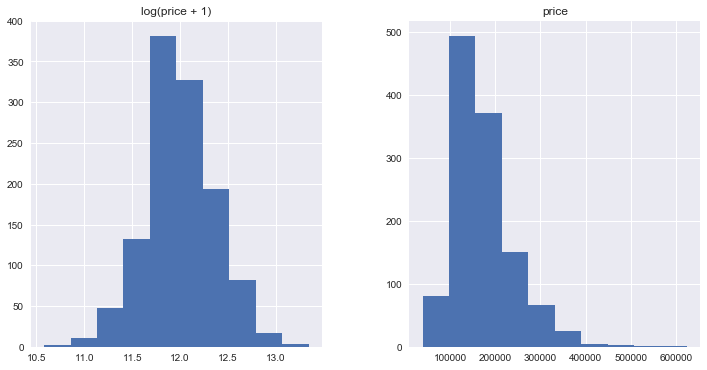

In [25]:
#this here shows the differences between the after and before effects of taking the log on the sales price

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [28]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

#the skewed features are:
skewed_feats

Index([u'1stFlrSF', u'3SsnPorch', u'BsmtFinSF2', u'BsmtHalfBath', u'BsmtUnfSF',
       u'EnclosedPorch', u'GrLivArea', u'KitchenAbvGr', u'LotArea',
       u'LotFrontage', u'LowQualFinSF', u'MSSubClass', u'MasVnrArea',
       u'MiscVal', u'OpenPorchSF', u'PoolArea', u'ScreenPorch', u'WoodDeckSF'],
      dtype='object')

In [29]:
# http://stackoverflow.com/a/24109916
#returns a new column for each unique item in a categorical variable (non numeric ones). 
#The value in the column indicates whether or not the record has that attribute

all_data = pd.get_dummies(all_data)

In [30]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [34]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [35]:
#define a function that returns the cross-validation rmse error so we 
#can evaluate our models and pick the best tuning par

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV,SGDRegressor,LogisticRegressionCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)